# Import/Export-Adjusted Green House Gas Emissions
## Final Assignment for EPA1333 Computer Engineering for Scientific Computing

Authors:

Patrick Steinmann #4623991

Stefan Wigman     #4016246







## Abstract

High-pollutant industrial processes often take place in developing countries, the resulting products often being exported to developed countries. We analyze this "offshoring" of green house gas (GHG) emissions by considering country-to-country import/export balances and national GHG emissions. We attempt to assign each country each it's "true" GHG emissions by determining which emissions that country causes in other countries, and then attributing these "offshored" emissions accordingly. We find that #TODO

## Introduction

In partial fulfillment of the course requirements of EPA1333, we were tasked to conduct an original and non-trivial data analysis related to climate change.

We chose to investigate the phenomenon of "outsourcing" green house gas (GHG) emissions. Many emission-intensive activities take place in countries with poor emissions records - however, these countries often export the products of these activities to countries with much better emissions records. In essence, the emissions are being outsourced. A simple example is the import of electrical energy - highly polluting coal is burned in a power plant in poorly developed country A, and the generated energy is exported to highly developed country B. Country B can claim low GHG emissions - after all, the coal is being burned in A, which, as a poorly developed country, has much more leeway regarding pollution. However, the resulting emissions should really be attributed to country B, since that is where the energy ends up.

Our research question therefore is as follows:

*How do countries' claimed GHG emissions compare to their true emissions, when accounting for offshoring of emissions through import/export?*

## Methodology

### Approach

We tackled our research question by first finding, importing and cleaning import/export data between countries. Specifically, we were interested in total import/export (that is, goods and services) from and to each country. We did not differentiate by type of goods.

We then obtained data on every country's GDP and GHG emissions. These emissions are reported as total GHG emitted over a year in a country, irrespective of use/destination.

$ emissions_{nominal} = emissions_{self} + emissions_{export} $

By comparing export volume and GDP, we were able to estimate which percentage of a country's GHG emissions are "self-caused", and which are "offshored" - that is, emissions created by products destined to by exported. In essence, these emissions could be attributed to the country importing those products, not the emittant's.

We then assigned each country, based on its imports, a percentage of their import partners' GHG emissions, thus arriving at each country's import/export adjusted (or "true") emissions.

$ emissions_{true} = emissions_{self} + emissions_{import} $

Finally, we presented the resulting data in various ways using different visualization packages.

### Assumptions & Simplifications
We assume that every country exports a broadly similar product palette to every export partner - that is, if country X produces apples, boats and cars, it exports all three to both Y and Z, not just apples to Y and boats and cars to Z.

To simplify our analysis, we ignore re-export and -import of goods. The data is available, but it would significantly complicate the attribution of emissions.

## Results/Work

### Setup

In a first step, we import all packages used throughout this notebook. These packages add functionality and features. Most of the packages are Anaconda-default. wbdata is the exception - this package is essentially an API for accessing World Bank Development Indicators data in an efficient, pandas-integrated fashion.

We also import a custom .py file called ProjectFunctions. It holds all the functions created for and applied in this analysis. Maintaining an external functions package keeps this notebook cleaner and easier to understand.

Note: It is technically considered bad form to import entire packages. The more Pythonic approach would be to only import specifically those functions which we require for our analysis.

In [48]:
import requests
import pandas as pd
from pathlib import Path
import numpy as np
import os
from ProjectFunctions import *
import datetime
import wbdata
import matplotlib.pyplot as plt

We override a default pandas option to make chained assignments not throw warnings.

In [2]:
pd.options.mode.chained_assignment = None  # default='warn'

As we intend to use a pandas multi-index dataframe, we create an IndexSlice object to make multi index slicing syntax more natural. This is optional.

In [3]:
idx = pd.IndexSlice

### Data Import & Cleaning

#### Country to Country Trade Data

We first import the raw country-to-country trade data from a CSV file, using suitable encoding.

In [4]:
trade_data=pd.read_csv("raw_data/DataJobID-1257172_1257172_TestQuery.csv" , encoding = "ISO-8859-1")

A thorny aspect of dealing with country-level data is the wildly differing standards for labelling the data. Various databases use full country names in various spellings, two-character ISO codes, three-character ISO codes, three-character IOC (International Olympic Committee) codes, or other identifiers. Thus, data alignment can be an issue. We decide to use ISO3 as our common identifier, and therefore create a dictionary to manage the conversions.

In [5]:
dic_cols=['ReporterISO3', 'ReporterName']
dic_df=trade_data[dic_cols].drop_duplicates()
country_dic=dic_df.set_index('ReporterName')['ReporterISO3'].to_dict()
inv_country_dic = {v: k for k, v in country_dic.items()}

We intend to build a multi-index dataframe to hold trade data between countries over a range of years. Multi-index dataframes are n-dimensional dataframes. In our case, we will use three dimensions - for each year (time being the third dimension), a two-dimensional dataframe holds the country-to-country trade data.

To build the multi-index, we need to define the indices first.

In [6]:
years = list(range(1995,2016))
countries=list(trade_data['ReporterName'].unique())

We can then build the structure of the multi-index dataframe.

In [7]:
data = build_multi_index_df(years,countries)

We can then fill the structure with values from the trade data. This iterative approach is quite slow. We use iPython magic to measure execution time. Anecdotally, execution time seems to be around 6-8 minutes.

In [ ]:
%%timeit -n1 -r1

#Caution, takes roughly 6-8 minutes!
for index, row in trade_data.iterrows():
    for year in years:
        year_key=str(year)+" in 1000 USD "
        data.loc[year][row['ReporterName']][row['PartnerName']]=row[year_key]

This data contains many NaN (Not a Number) values, which we fill with 0.

In [ ]:
data_filled=data.fillna(0)

To make data handling easier, we write the created multi-index dataframe to a TSV (tab-separated values) file.

In [ ]:
data_filled.to_csv('trade_data.tsv', sep='\t')

We then re-import that TSV file. This makes working with the data much easier, as we don't have to recreate it every time we run the notebook, we can just load it from the TSV file.

In [8]:
imported_data = pd.read_table('trade_data.tsv', index_col=[0,1])

To ensure the data has not been re-shaped during the write/read, we compare it to the original.

In [10]:
all(imported_data == data_filled)

NameError: name 'data_filled' is not defined

#### World Bank: World Development Indicators Data

In an external Excel sheet, we first define which WDI indicators we would like to import through the wbdata API.

In [11]:
indicator_dataframe, indicators, tabnames=GetIndicatorsWB(file='Selected_Indicators.xlsx', sheet='Indicators')

We first import income and region data for every country.

In [12]:
countries1=GetRegionIncomeDataWB()

We then import WDI data for the selected indicators based on 2015 numbers. Our custom function for this attempts to fill in missing values using older data where possible, going back to 2010 at the earliest.

In [13]:
wbdata = GetDataWB(indicators,2010, 2015)

We add the indicators data to the countries' income and region data.

In [14]:
wb_data_countries = countries1.join(wbdata, how='inner')

To account for missing income data, we use two functions. The first function identifies which countries are missing data, and then attempts to find other countries in that country's region with comparable income levels to fill the data. We do this because we assume that similarly developed countries in the same region will have comparable WDI indicators statistics.

As this does not cover all countries, we then run a simplified version of this method, matching only on region. This guarantees that there will be data for every country, but the data is less accurate.

In [15]:
region_income_data=FillByRegionAndIncomeWB(wb_data_countries)
region_income_data=FillByRegionWB(region_income_data)

We verify that we have a complete data set using another custom function.

In [16]:
DataCompleteness(region_income_data)

Country Data                                                    100.0
Region                                                          100.0
IncomeGroup                                                     100.0
Exports of goods and services (% of GDP)                        100.0
GDP (current US$)                                               100.0
Total greenhouse gas emissions (kt of CO2 equivalent)           100.0
Exports of goods and services (% of GDP) source                 100.0
GDP (current US$) source                                        100.0
Total greenhouse gas emissions (kt of CO2 equivalent) source    100.0
dtype: float64


We create a dictionary to match country names to codes, and vice versa. We will be able to use this to match country names spelled differently in various datasets.

In [17]:
dic_cols_wb=countries1['Country Data']
country_dic_wb=dic_cols_wb.to_dict()
inv_country_dic_wb = {v: k for k, v in country_dic_wb.items()}

We compare the dictionaries for World Bank data and trade data to find discrepancies in country names.

In [18]:
for item in inv_country_dic_wb:
    if item in inv_country_dic:
        continue
    else:
        print(item, inv_country_dic_wb[item])
        
print('---------------------------')
for item in inv_country_dic:
    if item in inv_country_dic_wb:
        continue
    else:
        print(item, inv_country_dic[item])

ASM American Samoa
VGB British Virgin Islands
CYM Cayman Islands
TCD Chad
CHI Channel Islands
COD Congo, Dem. Rep.
CUW Curacao
GNQ Equatorial Guinea
GIB Gibraltar
GUM Guam
IMN Isle of Man
PRK Korea, Dem. People���s Rep.
XKX Kosovo
LBR Liberia
LIE Liechtenstein
MHL Marshall Islands
FSM Micronesia, Fed. Sts.
MCO Monaco
MNE Montenegro
NRU Nauru
MNP Northern Mariana Islands
PRI Puerto Rico
ROU Romania
SMR San Marino
SRB Serbia
SXM Sint Maarten (Dutch part)
SOM Somalia
SSD South Sudan
MAF St. Martin (French part)
TLS Timor-Leste
UZB Uzbekistan
VIR Virgin Islands (U.S.)
---------------------------
AIA Anguila
ANT Netherlands Antilles
BLX Belgium-Luxembourg
COK Cook Islands
EUN European Union
GLP Guadeloupe
GUF French Guiana
MNT Montenegro
MSR Montserrat
MTQ Martinique
MYT Mayotte
OAS Other Asia, nes
REU Reunion
ROM Romania
SER Serbia, FR(Serbia/Montenegro)
SUD Sudan
TMP East Timor


Differences in spelling are reasily recognized, the appropriate conversions are written to a conversion dictionary.

In [19]:
conversion_dic={'SER':'SRB',
               'SUD':'SSD',
               'ROM':'ROU'}

### Shaping Data

#### Trade Percentages

Our data for trade between countries is currently in thousand USD. We align the data by instead expressing it in percentages - that is, X percent of country A's total exports go to country B, Y percent go to country C, etc. This will make the emissions calculations easier to execute later on.

We first make a copy of the multi-index dataframe imported from the trade data TSV file. This ensures we don't accidentally manipulate our base data.

In [20]:
percentages_multi = imported_data.copy()

We then calculate the percentage-wise exports for every exporter for every year ("layer") in the multi-index dataframe.

In [21]:
for year in years:
    this = percentages_multi.loc[year].div(percentages_multi.loc[year].sum(axis=1), axis=0)
    this_filled = this.fillna(0)
    percentages_multi.loc[year].update(this_filled)

To see how much data is available, we build a custom dataframe showing the year-wise export destinations for each exporter. In other words, we can see, for each year, how many countries every country exported to.

As the first year is used to build the dataframe, and then additional years are attached as columns, the first year must be skipped in the iterator. pd.assign() interprets the given column ("temp") literally, therefore, the column names must be re-written in each iteration loop.

In [22]:
data_points = (percentages_multi.loc[1995] != 0).sum(axis=1).to_frame()
data_points.columns = ['1995']

i=1
for year in years[1:]:
    i=i+1
    this = (percentages_multi.loc[year] != 0).sum(axis=1)
    data_points = data_points.assign(temp = this)
    data_points.columns = [years[:i]]
    
data_points

,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,...,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
exporter,,,,,,,,,,,,,,,,,,,,,
Aruba,38,48,52,49,59,63,68,66,70,72,...,76,76,72,80,78,78,80,77,82,76
Afghanistan,57,63,64,71,68,74,72,85,89,93,...,94,96,97,105,105,97,98,96,91,94
Angola,65,76,75,81,88,100,104,106,108,114,...,111,117,114,118,120,125,119,117,116,111
Anguila,33,35,47,45,47,55,48,50,57,56,...,60,56,61,61,65,60,59,56,53,54
Albania,60,65,67,71,74,77,81,87,86,86,...,96,98,102,103,97,106,98,98,96,97
Andorra,41,43,45,49,47,54,62,66,70,70,...,81,85,76,84,81,82,78,74,81,72
Netherlands Antilles,70,73,77,73,84,92,96,93,94,94,...,105,99,104,105,97,0,0,0,0,0
United Arab Emirates,94,102,110,111,119,134,135,135,143,144,...,147,152,151,148,157,155,151,150,144,140
Argentina,84,95,99,103,105,116,117,113,116,119,...,122,117,123,127,124,125,123,115,116,108


### Connecting Data

Nota bene: Due to time concerns, we were not able to conduct our analysis for multiple years. Instead, we decided to focus on a single year which, in our opinion, showed high data quality and availability. With more time, the analysis could easily have been conducted for all the years using the shown procedure.

We isolate a single yearly slice of the multi-index dataframe for analysis.

In [23]:
percentages = 0
percentages = percentages_multi.loc[2014]

# percentages=pd.DataFrame()
# percentage_to_country=imported_data.loc[2014]/imported_data.loc[2014].sum(axis=0)
# percentages=percentages.append(percentage_to_country)
# percentages=percentages.fillna(0)
#TODO decide.

In [24]:
percentages

,Aruba,Afghanistan,Angola,Anguila,Albania,Andorra,Netherlands Antilles,United Arab Emirates,Argentina,Armenia,...,United States,St. Vincent and the Grenadines,Venezuela,Vietnam,Vanuatu,Samoa,Yemen,South Africa,Zambia,Zimbabwe
exporter,,,,,,,,,,,,,,,,,,,,,
Aruba,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.334162e-07,0.0,1.678291e-07,0.000372,0.000000e+00,...,0.332989,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000118,0.000000e+00,0.000000e+00
Afghanistan,0.000000e+00,0.0,0.000000e+00,0.0,3.202126e-08,1.242547e-07,0.0,3.437326e-02,0.000188,3.856340e-05,...,0.103815,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000262,0.000000e+00,0.000000e+00
Angola,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,3.124578e-03,0.003622,3.836924e-07,...,0.053515,0.0,0.0,2.323543e-03,0.0,0.000000e+00,0.000000e+00,0.029978,2.311508e-04,0.000000e+00
Anguila,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,0.566621,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000667,0.000000e+00,0.000000e+00
Albania,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,5.020802e-07,0.0,4.667453e-04,0.000304,3.107701e-08,...,0.006105,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000037,0.000000e+00,0.000000e+00
Andorra,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.890660e-05,0.000000,1.472950e-06,...,0.001143,0.0,0.0,1.127127e-07,0.0,0.000000e+00,3.138665e-06,0.000010,0.000000e+00,1.280826e-06
Netherlands Antilles,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000,0.000000e+00,...,0.000000,0.0,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
United Arab Emirates,0.000000e+00,0.0,3.010531e-03,0.0,5.355119e-06,4.263031e-07,0.0,0.000000e+00,0.000694,3.099588e-05,...,0.064999,0.0,0.0,1.605215e-02,0.0,0.000000e+00,7.979394e-05,0.004813,8.009168e-04,3.333443e-04
Argentina,0.000000e+00,0.0,0.000000e+00,0.0,9.458895e-07,7.415208e-07,0.0,1.318755e-04,0.000000,4.449570e-09,...,0.141253,0.0,0.0,2.580751e-03,0.0,0.000000e+00,1.952456e-06,0.003169,0.000000e+00,3.037573e-08


We merge the percentages dataframe and the WB data dataframe into one using a custom function, which accounts for different country name spellings by comparing them to the dictionaries created earlier. This will make dataframe operations easier.

In [25]:
filled_dataframe=MergeDataFrames(region_income_data, percentages, country_dic_wb, country_dic, conversion_dic)        

Countries without complete data (NaN) are removed.

In [26]:
filled_dataframe=filled_dataframe.dropna(how='any')

We can check how many countries are left by seeing the length of the dataframe.

In [27]:
len(filled_dataframe)

188

We drop columns that we're currently not interested in.

In [28]:
dont_include=["Country Data",
              "Region",
              "IncomeGroup",
              "GDP (current US$)",
              "Total greenhouse gas emissions (kt of CO2 equivalent)",
              "GDP (current US$) source",
              "Total greenhouse gas emissions (kt of CO2 equivalent) source",
             'Exports of goods and services (% of GDP) source',
             'Exports of goods and services (% of GDP)']

export_cols=filled_dataframe.columns[~filled_dataframe.columns.isin(dont_include)]

Now we can find the sum of exports of each country.

In [29]:
filled_dataframe['SumOfExports'] = filled_dataframe[export_cols].sum(axis=1)

The redistributions to and from each country are calculated.

In [30]:
for column in export_cols:
    colname='Percentage to ' + column
    filled_dataframe[colname]=filled_dataframe[column]/filled_dataframe['SumOfExports']

The emissions are connected to the country GDPs and emissions.

In [31]:
filled_dataframe['EmissionForExport']=filled_dataframe['Total greenhouse gas emissions (kt of CO2 equivalent)']*(filled_dataframe["Exports of goods and services (% of GDP)"]/100)

We then assign each country the emissions it imports.

In [32]:
for column in export_cols:
    colname='Emissions to ' + column
    filled_dataframe[colname]=filled_dataframe['Percentage to ' + column]*filled_dataframe['EmissionForExport']

Now we can assign the emissions to the offshoring countries in a new set of columns. However, we will first remove countries with naming issues. These are almost all quite small countries (or territories), therefore this will not disrupt the analysis much.

In [33]:
emissions_cols=[col for col in filled_dataframe.columns if 'Emissions to' in col]

emissions_dataframe=pd.DataFrame(filled_dataframe[emissions_cols])
columns_to_remove=[]
for column in emissions_dataframe:
    country_name = column.replace('Emissions to ', '')
    if country_name not in emissions_dataframe.index:
        print('Removing', country_name)
        columns_to_remove.append('Emissions to '+country_name)
emissions_dataframe.drop(columns_to_remove, axis=1, inplace=True)

Removing Anguila
Removing Netherlands Antilles
Removing Belgium-Luxembourg
Removing Cook Islands
Removing European Union
Removing Guadeloupe
Removing French Guiana
Removing Montserrat
Removing Martinique
Removing Mayotte
Removing Other Asia, nes
Removing Reunion
Removing Serbia, FR(Serbia/Montenegro)
Removing East Timor


In [34]:
emissions_cols=[col for col in filled_dataframe.columns if 'Emissions to' in col]
emissions_to_countries=pd.DataFrame(filled_dataframe[emissions_cols].sum(axis=0))
emissions_to_countries=emissions_to_countries.reset_index()
emissions_to_countries.replace('Emissions to ','',regex=True,inplace=True)
emissions_to_countries.set_index('index', inplace=True)
emissions_to_countries.index.rename('exporter', inplace=True)

Finally, we add each country's own emissions to its' imported emissions, thus measuring every country's "true" emissions.

In [35]:
filled_dataframe['EmissionsToCountries']=emissions_to_countries[0]
filled_dataframe["NewEmissions"]=filled_dataframe['EmissionsToCountries']+(1-filled_dataframe["Exports of goods and services (% of GDP)"]/100)*filled_dataframe["Total greenhouse gas emissions (kt of CO2 equivalent)"]
filled_dataframe["EmissionDifference"]=(filled_dataframe["NewEmissions"]-filled_dataframe["Total greenhouse gas emissions (kt of CO2 equivalent)"])

### Visualizations

#### Interactive Globe: Emissions Caused Abroad

We want to visualize how a given country spreads its emissions across the globe by offshoring them. We define a custom function to visualize this. However, we first need to assign coordinates to each country. This is very messy, as we again run into problems with names and spelling, requiring some manual overrides. The coordinates are retrieved from a webserver through the GeoPy package.

In [36]:
filled_dataframe['Latitude']=None
filled_dataframe['Longitude']=None
for country in filled_dataframe.index:
    if country == 'China':
        country_wb="People's Republic of China"
    elif country =='Congo, Rep.':
        country_wb='Congo'
    elif country == 'Egypt, Arab Rep.':
        country_wb='Egypt'
    elif country == 'Iran, Islamic Rep.':
        country_wb='Iran'
    elif country=='Macao SAR, China':
        country_wb='Macau, China'
    elif country == 'Macedonia, FYR':
        country_wb='Macedonia'
    elif country == 'Yemen, Rep.':
        country_wb='Yemen'         
    elif country in country_dic:
        country_code=country_dic[country]
        if country_code in inv_country_dic_wb:
            country_wb=inv_country_dic_wb[country_code]
        else:
            country_wb=country
    else:
        country_wb=country
    coords=GetCountryCoordinates(country_wb)
    filled_dataframe['Latitude'][country]=coords[0]
    filled_dataframe['Longitude'][country]=coords[1]

No location found for Macao SAR, China
No location found for Yemen, Rep.


After finding all the coordinates, we can specify a country for which to visualize the offshoring. Here, we choose Belgium. The visualization creates an HTML-based interactive globe showing the "flows" of emissions.

In [43]:
VisualizeFlowsToCountry('Belgium', emissions_dataframe, filled_dataframe)

'file://C:\\Users\\Patrick\\Documents\\GitHub\\TrueEmissions\\EmissionFlowsBelgium.html'

Conversely, we can also visualize the flows out of a country - in other words, show for which countries a given country is shouldering emissions burden. Here, we use the USA as an example.

In [45]:
VisualizeFlowsFromCountry('United States', emissions_dataframe, filled_dataframe)

'file://C:\\Users\\Patrick\\Documents\\GitHub\\TrueEmissions\\EmissionFlowsUnited States.html'

#### Nominal/True Emissions Comparison

In [46]:
filled_dataframe

,Aruba,Afghanistan,Angola,Anguila,Albania,Andorra,Netherlands Antilles,United Arab Emirates,Argentina,Armenia,...,Emissions to Samoa,Emissions to Yemen,Emissions to South Africa,Emissions to Zambia,Emissions to Zimbabwe,EmissionsToCountries,NewEmissions,EmissionDifference,Latitude,Longitude
exporter,,,,,,,,,,,,,,,,,,,,,
Aruba,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,1.334162e-07,0.0,1.678291e-07,0.000372,0.000000e+00,...,0,0,2.36146,0,0,5.167330e+01,8328.57,-19989.9,12.5014,-69.9618
Afghanistan,0.000000e+00,0.0,0.000000e+00,0.0,3.202126e-08,1.242547e-07,0.0,3.437326e-02,0.000188,3.856340e-05,...,0,0,0.329852,0,0,4.935796e+02,17215.8,-765.493,33.768,66.2385
Angola,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,3.124578e-03,0.003622,3.836924e-07,...,0,0,423.674,3.26687,0,7.080297e+04,98327.1,56669.9,-11.8776,17.5691
Albania,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,5.020802e-07,0.0,4.667453e-04,0.000304,3.107701e-08,...,0,0,0.0895904,0,0,3.929060e+03,10402,1503.36,11.2449,-72.5161
Andorra,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,1.890660e-05,0.000000,1.472950e-06,...,0,0.330012,1.0841,0,0.134671,3.516004e+01,59376.7,-105109,42.5407,1.5732
United Arab Emirates,0.000000e+00,0.0,3.010531e-03,0.0,5.355119e-06,4.263031e-07,0.0,0.000000e+00,0.000694,3.099588e-05,...,0,16.4152,990.137,164.764,68.5755,5.547633e+04,54645.4,-150243,24.0002,53.9995
Argentina,0.000000e+00,0.0,0.000000e+00,0.0,9.458895e-07,7.415208e-07,0.0,1.318755e-04,0.000000,4.449570e-09,...,0,0.081739,132.675,0,0.00127167,7.973897e+04,418170,37874.3,-34.9965,-64.9673
Armenia,0.000000e+00,0.0,0.000000e+00,0.0,1.834978e-05,2.543786e-08,0.0,2.839933e-03,0.001116,0.000000e+00,...,9.67098e-05,0,0.561901,0.000444643,0,1.606758e+03,10255.4,-2063.95,4.49227,-75.7396
Antigua and Barbuda,0.000000e+00,0.0,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,2.041421e-05,0.000366,0.000000e+00,...,0,0,1.03614,4.55275e-05,0,1.407642e+01,321.287,-231.461,17.0791,-61.8223


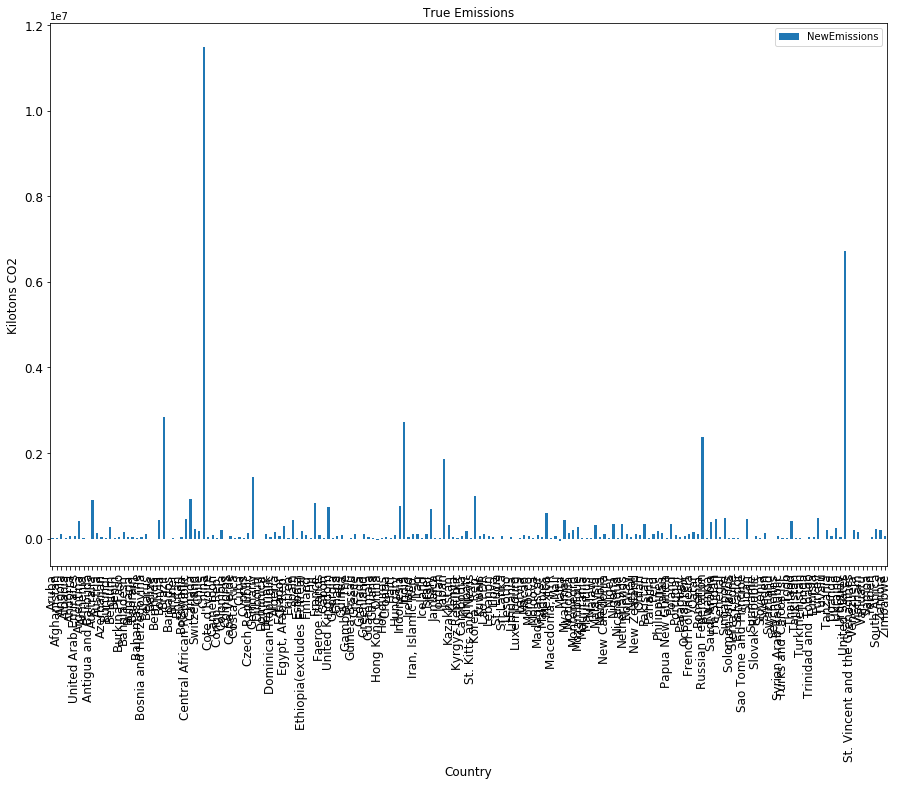

In [51]:
#plt.figure();

#filled_dataframe.loc['NewEmissions'].plot(kind='bar');


ax = filled_dataframe[['NewEmissions']].plot(kind='bar', title ="True Emissions", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Country", fontsize=12)
ax.set_ylabel("Kilotons CO2", fontsize=12)
plt.show()

## Analysis

#discuss why data cleaning/interpolation/completion only for WB data, not trade data

## Conclusion

future work could account for different types of goods, which in turn cause different amounts of pollution. would allow more accurate attribution of emissions.

## Reflection

As this is a learning assignment, we decided to note some thoughts and significant learning experiences gathered during the work on this analysis.

Our first key learning is that data analysis is messy. Databases have different sizes, naming conventions and classifications. Additionally, data is often missing. We struggled most with the different names and codes for the various codes, which required significant effort to compare, align and modify to work together.

Similarly, we found it both necessary and valuable to constantly check our dataframes for size and completeness. We even wrote a custom function just to check this completeness, which saved a lot of time.

We implemented a custom .py file to hold all our functions. This helped to keep our report tidy. However, we did notice that most of our functions are only called once - thus making it somewhat pointless to implement them as callable, fruitful functions. However, if we would have had time to expand our analysis to time series rather than just a single year, this might have become more useful.

Finally, we used GitHub to do version management on this project. Neither of us had significant previous experience with it, and we probably did not make full use of the git functionalities. However, we did find it made file sharing easier. On a previous project, we had a "power user" in our group who had significant GitHub experience, this made the process much easier when more advanced operations beyond push/pull were required. However, we were able to gain valuable experience through this assignment.

## Data Sources

* World Bank: World Development Indicators (accessed through Python API): https://data.worldbank.org/data-catalog/world-development-indicators
* World Bank: World Integrated Trade Solution (CSV downloaded from web query): https://wits.worldbank.org/Default.aspx?lang=en